In [1]:
#attempt to improve the NN
#add the local and the global view construct coz transit false positive mismatch seems to be a major problem
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from keras import backend as K
import GetLightcurves as gc

In [3]:

def _parse_tfr_element(element):
  desc = {
        'input':tf.io.FixedLenFeature([], tf.string),
        'map':tf.io.FixedLenFeature([], tf.string),
        'counts': tf.io.FixedLenFeature([], tf.string),
        'id': tf.io.FixedLenFeature([], tf.string),  
    }
  example_message = tf.io.parse_single_example(element, desc)

  #return(example_message['counts'])
  binp = example_message['input'] # get byte 
  bmap = example_message['map'] # get byte string
  bcts = example_message['counts'] # get byte string
  bid = example_message['id'] # get byte string
  print(binp.shape,bmap.shape,bcts.shape)
  inp = tf.io.parse_tensor(binp, out_type=tf.float32) # restore 2D array from byte string
  map = tf.io.parse_tensor(bmap, out_type=tf.bool)
  cts = tf.io.parse_tensor(bcts, out_type=tf.int8)
  id = tf.io.parse_tensor(bid, out_type=tf.string)
  return (inp,map,cts,id)


tfr_dataset = tf.data.TFRecordDataset(['../../training_data/seg_mask_training_av_bal']) 
tfr_testdata = tf.data.TFRecordDataset(['../../training_data/seg_mask_test_av_bal']) 
#for serialized_instance in tfr_dataset:
#  print(serialized_instance) # print serialized example messages
#zprint(len(tfr_dataset))
dataset = tfr_dataset.map(_parse_tfr_element)
testdata = tfr_testdata.map(_parse_tfr_element)

Xtrain=[]
Ytrain=[]

for instance in dataset:
  Xtrain.append(instance[0])
  Ytrain.append(instance[1])

Xtest=[]
Ytest=[]
TestID=[]

for instance in testdata:
  Xtest.append(instance[0])
  Ytest.append(instance[1])
  TestID.append(instance[3])

() () ()
() () ()


In [4]:
Ytrain=np.asarray(Ytrain).reshape(len(Xtrain),4000,3)
Ytest=np.asarray(Ytest).reshape(len(Xtest),4000,3)
print(Ytrain.shape, Ytest.shape)

(3278, 4000, 3) (820, 4000, 3)


In [5]:

Xtrain=np.asarray([(row-np.median(row))/(-row[np.argmin(row)]+np.median(row)) for row in Xtrain])
Xtest=np.asarray([(row-np.median(row))/(-row[np.argmin(row)]+np.median(row)) for row in Xtest])

<function matplotlib.pyplot.show(close=None, block=None)>

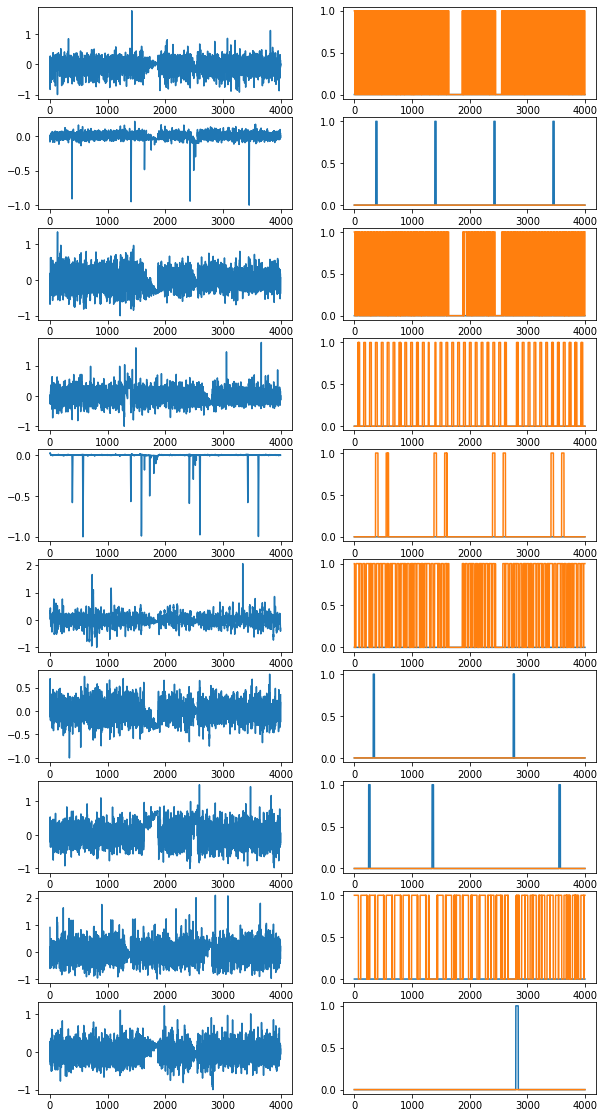

In [6]:
Ytrain = np.asarray(Ytrain, dtype = 'float32')
Ytest = np.asarray(Ytest, dtype = 'float32')
vararr=np.random.randint(0,len(Xtrain),size=10)
fig,ax=plt.subplots(10,2,figsize=(10,20))
for i in range(0,10):
    ax[i][0].plot(Xtrain[vararr[i]])
    #ax[i][1].plot(Ytrain[vararr[i],:,2])
    ax[i][1].plot(Ytrain[vararr[i],:,0])
    ax[i][1].plot(Ytrain[vararr[i],:,1])
    #ax[i][1].set_xlim(2600,3000)
plt.show

In [7]:
ALPHA = 0.8
GAMMA = 2

def FocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

def log_cosh_dice_loss(y_true, y_pred):
        x = generalized_dice_coeff(y_true, y_pred)
        return tf.math.log((tf.exp(x) + tf.exp(-x)) / 2.0)

def bce_dice_loss(y_true, y_pred):
    loss = keras.losses.binary_crossentropy(y_true, y_pred)*0.5 + log_cosh_dice_loss(y_true, y_pred)
    return loss

def generalized_dice_coeff(y_true, y_pred):
    # Compute weights: "the contribution of each label is corrected by the inverse of its volume"
    w = tf.reduce_sum(y_true,(0,1))
    w= w/tf.linalg.norm(w)
    w = 1 / (w  + 0.00001)
    #w = 1 - w
    #w = w**2
    w=tf.cast(w,tf.float32)


    numerator = y_true * y_pred
    numerator = w * K.sum(numerator, (0, 1))
    numerator = K.sum(numerator)

    denominator = y_true + y_pred
    denominator = w * K.sum(denominator, (0, 1))
    denominator = K.sum(denominator)

    gen_dice_coef = numerator / denominator

    return 1 - 2 * gen_dice_coef

def loss_wrap(alpha=1,gamma=2,comb=1):
    def focal_dice_loss(y_true, y_pred):
        loss = FocalLoss(y_true, y_pred, alpha, gamma) + comb*log_cosh_dice_loss(y_true, y_pred)
        return loss
    return focal_dice_loss





In [8]:
def build_model(hp):
    hp_f = hp.Int('units1', min_value=8, max_value=32, step=8)
    hp_bottle = hp.Int('units4', min_value=256, max_value=1024, step=256)
    hp_alp = hp.Float('alp', min_value=0.4, max_value=0.8, step=0.2)
    hp_gamma = hp.Choice('gamma', values=[1, 2, 3, 4])
    hp_comb = hp.Choice('lincomb', values=[1.0, 1.5, 2.0, 2.5])

    IMG_SIZE=2000

    conv_ip = keras.layers.Input(shape=(IMG_SIZE,),name='Input')
    xi=keras.layers.Reshape((IMG_SIZE, 1), input_shape=(IMG_SIZE,),name='reshape_1')(conv_ip)
    xi=keras.layers.BatchNormalization()(xi)

    x1=keras.layers.SeparableConv1D(hp_f,kernel_size=3,strides=1,activation='tanh',name='1st16_5')(xi)  #3998, 32
    c1=keras.layers.SeparableConv1D(hp_f,kernel_size=3,strides=1,activation='tanh',name='2nd16_3')(x1)  #3996, 32

    x2=keras.layers.BatchNormalization(name='bn1')(c1)
    x2=keras.layers.MaxPool1D(2,strides=2 ,data_format='channels_last',name='maxpool_1')(x2)  #1998, 64
    x2=keras.layers.SeparableConv1D(hp_f*2,kernel_size=3,strides=1,activation='tanh',name='1st32_5')(x2) #1996, 64
    c2=keras.layers.SeparableConv1D(hp_f*2,kernel_size=5,strides=1,activation='tanh',name='2nd32_3')(x2) #1992, 64

    x3=keras.layers.BatchNormalization(name='bn2')(c2) 
    x3=keras.layers.MaxPool1D(2,strides=2 ,data_format='channels_last',name='maxpool_2')(x3)  #996, 64
    x3=keras.layers.SeparableConv1D(hp_f*4,kernel_size=3,strides=1,activation='tanh',name='1st64_5')(x3) #994, 128
    c3=keras.layers.SeparableConv1D(hp_f*4,kernel_size=3,strides=1,activation='tanh',name='2nd64_3')(x3) #992, 128

    x4=keras.layers.BatchNormalization(name='bn3')(c3)
    x4=keras.layers.MaxPool1D(2,strides=2 ,data_format='channels_last',name='maxpool_3')(x4)  #496, 128
    x4=keras.layers.SeparableConv1D(hp_f*8,kernel_size=3,strides=1,activation='tanh',name='1st128_5')(x4)  #494, 256
    c4=keras.layers.SeparableConv1D(hp_f*8,kernel_size=3,strides=1,activation='tanh',name='2nd128_5')(x4) #492, 256

    x5=keras.layers.BatchNormalization(name='bn4')(c4) 
    x5=keras.layers.MaxPool1D(2,strides=2,data_format='channels_last',name='maxpool_4')(x5)  #246, 256  
    x5=keras.layers.SeparableConv1D(hp_bottle,kernel_size=3,strides=1,activation='tanh',name='1st512_5')(x5)  #244, 256
    x5=keras.layers.SeparableConv1D(hp_bottle,kernel_size=3,strides=1,activation='tanh',name='2nd512_5')(x5)  #242, 256

    x5 = keras.layers.Conv1DTranspose(hp_f*8, kernel_size=4, activation='relu', strides=2, name="T1st128_5")(x5)  #486, 256
    x5 = keras.layers.Conv1DTranspose(hp_f*8, kernel_size=5, activation='relu', strides=1, name="T2nd128_5")(x5)  #490, 256
    x5 = keras.layers.Conv1DTranspose(hp_f*8, kernel_size=3, activation='relu', strides=1, name="T3rd128_5")(x5)  #492, 256
    x5 =keras.layers.BatchNormalization(name='bn5')(x5) 

    x6 = keras.layers.Concatenate(axis=2, name='cn1')([c4,x5])  #492, 512
    x6 = keras.layers.Conv1DTranspose(hp_f*8,kernel_size=3,strides=1,activation='relu',name='3rd128_3')(x6) #494, 256
    x6 = keras.layers.Conv1DTranspose(hp_f*4, kernel_size=4, activation='relu', strides=2, name="T1st64_3")(x6) #990, 128
    x6 = keras.layers.Conv1DTranspose(hp_f*4, kernel_size=3, activation='relu', strides=1, name="T2nd64_3")(x6) #992, 128
    x6 = keras.layers.BatchNormalization(name='bn6')(x6)  

    x7 = keras.layers.Concatenate(axis=2, name='cn2')([c3,x6]) #992, 256
    x7 = keras.layers.Conv1DTranspose(hp_f*4,kernel_size=3,strides=1,activation='relu',name='3rd64_3')(x7) #994, 128
    x7 = keras.layers.Conv1DTranspose(hp_f*2, kernel_size=4, activation='relu', strides=2, name="T1st32_3")(x7) #1990, 64
    x7 = keras.layers.Conv1DTranspose(hp_f*2, kernel_size=3, activation='relu', strides=1, name="T2nd32_3")(x7) #1992, 64
    x7 = keras.layers.BatchNormalization(name='bn7')(x7)  

    x8 = keras.layers.Concatenate(axis=2, name='cn3')([c2,x7])  #1992, 128
    x8 = keras.layers.Conv1DTranspose(hp_f*2,kernel_size=3,strides=1,activation='relu',name='3rd32_3')(x8)  #1994, 64
    x8 = keras.layers.Conv1DTranspose(hp_f,kernel_size=4,strides=2,activation='relu',name='T1st16_3')(x8) #3990, 32
    x8 = keras.layers.Conv1DTranspose(hp_f,kernel_size=5,strides=1,activation='relu',name='T2nd16_3')(x8) #3994, 32
    x8 = keras.layers.Conv1DTranspose(hp_f,kernel_size=3,strides=1,activation='relu',name='T4rth16_3')(x8) #3996, 32
    x8 = keras.layers.BatchNormalization(name='bn8')(x8)  

    x9 = keras.layers.Concatenate(axis=2, name='cn4')([c1,x8])  #3996, 64
    x9 = keras.layers.Conv1DTranspose(hp_f,kernel_size=3,strides=1,activation='relu',name='3rd16_3')(x9) #3998, 32
    x9 = keras.layers.Conv1DTranspose(hp_f,kernel_size=3,strides=1,activation='relu',name='T3rd16_3')(x9) #4000, 32
    x9 = keras.layers.BatchNormalization(name='bn9')(x9)

    conv_op = keras.layers.Conv1D(3,kernel_size=3,strides=1,name='semiop',padding='same',activation='softmax')(x9) # (4000, 3)

    #keras.backend.clear_session()
    convNN = keras.Model(inputs=conv_ip, outputs=conv_op,name='Convolutional_NN')

    convNN.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss=loss_wrap(alpha=hp_alp,gamma=hp_gamma,comb=hp_comb), metrics=[tf.keras.metrics.MeanIoU(num_classes=3)])
    return convNN

In [9]:
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=10,
    directory='tune4800',
    project_name='keras_tuner_demo'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(np.asarray(Xtrain[:,1000:3000]), np.asarray(Ytrain[:,1000:3000,:]), epochs=10, batch_size=16,validation_split=0.2,callbacks=[stop_early])

Trial 1 Complete [00h 02m 10s]
val_loss: 0.471743106842041

Best val_loss So Far: 0.471743106842041
Total elapsed time: 00h 02m 10s

Search: Running Trial #2

Hyperparameter    |Value             |Best Value So Far 
units1            |8                 |16                
units4            |1024              |1024              
alp               |0.6               |0.6               
gamma             |4                 |2                 
lincomb           |1                 |1.5               
tuner/epochs      |2                 |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |2                 |2                 
tuner/round       |0                 |0                 

Epoch 1/2
164/164 [==============================] - 47s 234ms/step - loss: 0.3703 - mean_io_u: 0.3333 - val_loss: 0.3470 - val_mean_io_u: 0.3333
Epoch 2/2
 61/164 [==========>...................] - ETA: 20s - loss: 0.3339 - mean_io_u: 0.3333

In [ ]:
models = tuner.get_best_models(num_models=1)
bestHP = tuner.get_best_hyperparameters(num_trials=1)[0]
print(bestHP)